Möchten Sie Parameter aus einer Datei laden (l) oder neue Parameter eingeben (n)?  n
Die Breite des Rauschens.
breite (int >= 1):  
Die Höhe des Rauschens.
hoehe (int >= 1):  
Der Zeitpunkt, für den das Rauschen generiert wird.
t (float):  
Der Skalierungsfaktor in x-Richtung.
scale_x (float >= 0):  
Der Skalierungsfaktor in y-Richtung.
scale_y (float >= 0):  
Der Skalierungsfaktor in der Zeitdimension.
scale_t (float >= 0):  
Die Anzahl der Oktaven für das Perlin-Rauschen.
octaves (int >= 1):  
Die Persistenz für das Perlin-Rauschen.
persistence (float zwischen 0 und 1):  
Die Lacunarität für das Perlin-Rauschen.
lacunarity (float >= 1):  
Die Wiederholungsperiode des Rauschens in x-Richtung.
repeatx (int >= 0):  
Die Wiederholungsperiode des Rauschens in y-Richtung.
repeaty (int >= 0):  
Die Wiederholungsperiode des Rauschens in der Zeitdimension.
repeatz (int >= 0):  
Ein Startwert für den Zufallsgenerator.
base (int):  
Der Skalierungsfaktor für die rote Farbkomponente.
rot_scale (

Parameter erfolgreich gespeichert unter params/params.json


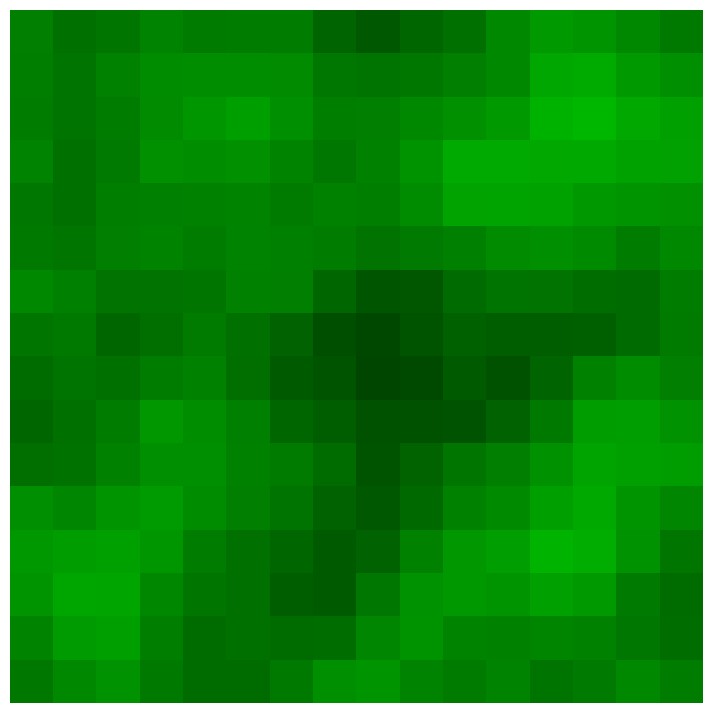

MovieWriter ffmpeg unavailable; using Pillow instead.


export/animation.gif gespeichert


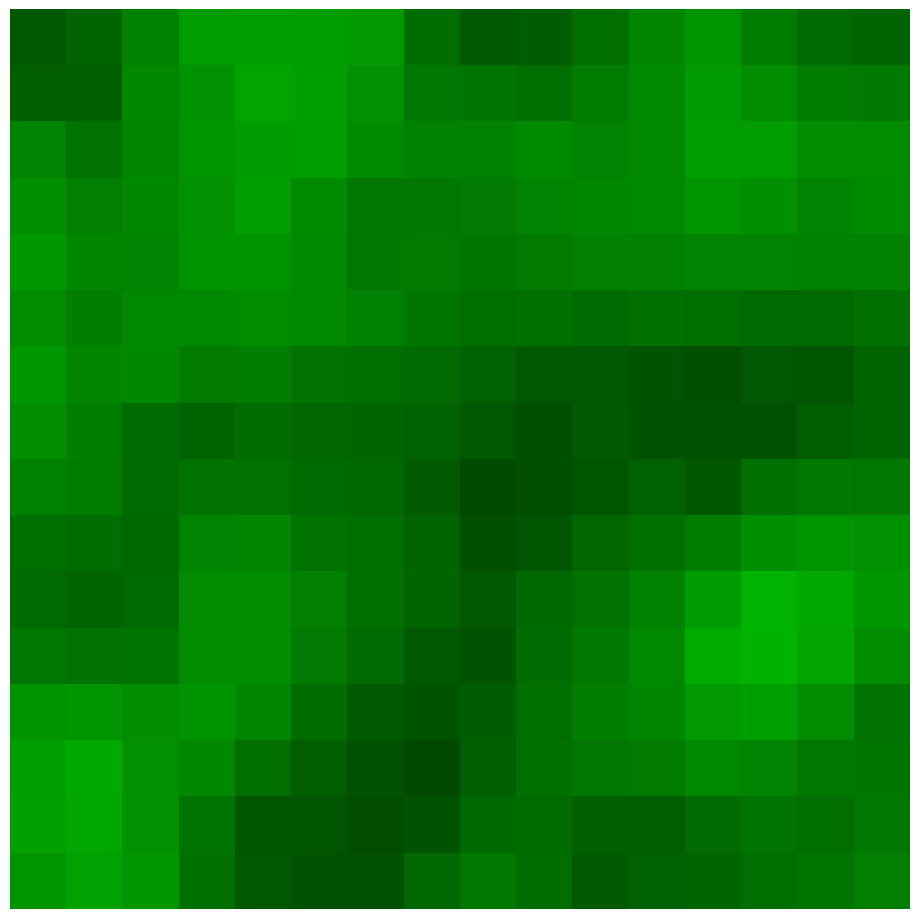

In [2]:
#import utils.functions as func

import src.file_handling as file_handling
import src.animation_generation as animation_generation
import src.image_generation as image_generation
import src.user_interface as user_interface

import matplotlib.pyplot as plt

def main():
    """
    Hauptfunktion des Skripts.

    Initialisiert die Parameter, generiert ein Bild, zeigt es an, erstellt eine Animation und speichert sie in einer Datei.
    """
    
    auswahl = user_interface.benutzer_parameter_abfrage()
    
    if auswahl == 'n':
        # User Eingabe zur Bestimmung der Parameter
        params_datei = user_interface.benutzer_parameter_eingabe_und_speichern()
            
    else:
        # User Eingabe zur Auswahl der params Datei
        params_datei = user_interface.user_params_datei_auswahl()

    # Laden Sie die Parameter aus der Datei
    params = file_handling.laden_params(params_datei)

    # Speichern Sie die Parameter in einer Datei
    file_handling.speichern_params(params, 'params/params.json')

    # Laden Sie die Parameter aus der Datei
    #params = file_handling.laden_params('params/params.json')

    # Generieren Sie ein Bild
    image = image_generation.generiere_bild(params)

    # Zeige das Bild an
    plt.figure(figsize=(16, 9))  # Optional: Ändern Sie die Größe des Bildes, hier 10x10 Zoll.
    plt.imshow(image)
    plt.axis('off')  # Schaltet die Achsen aus.
    plt.show()

    # Erstelle und speichere die Animation
    animation_generation.erstelle_und_speichere_animation(params, 'export/animation.gif')

if __name__ == "__main__":
    main()

Möchten Sie Parameter aus einer Datei laden (l) oder neue Parameter eingeben (n)?  l


0: params/default_params.json
1: params/params.json
Welche Datei soll geladen werden? (0 bis 1)


>  0


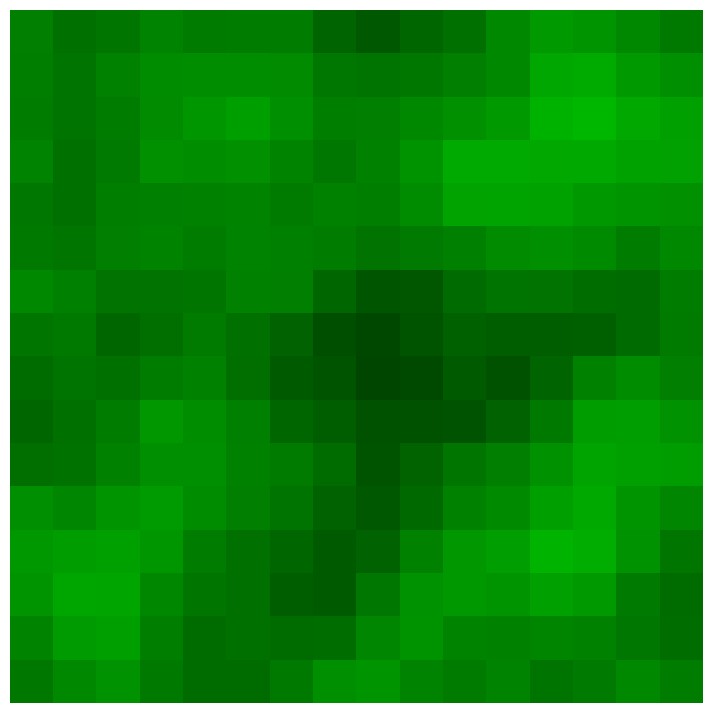

MovieWriter ffmpeg unavailable; using Pillow instead.


export/animation.gif gespeichert


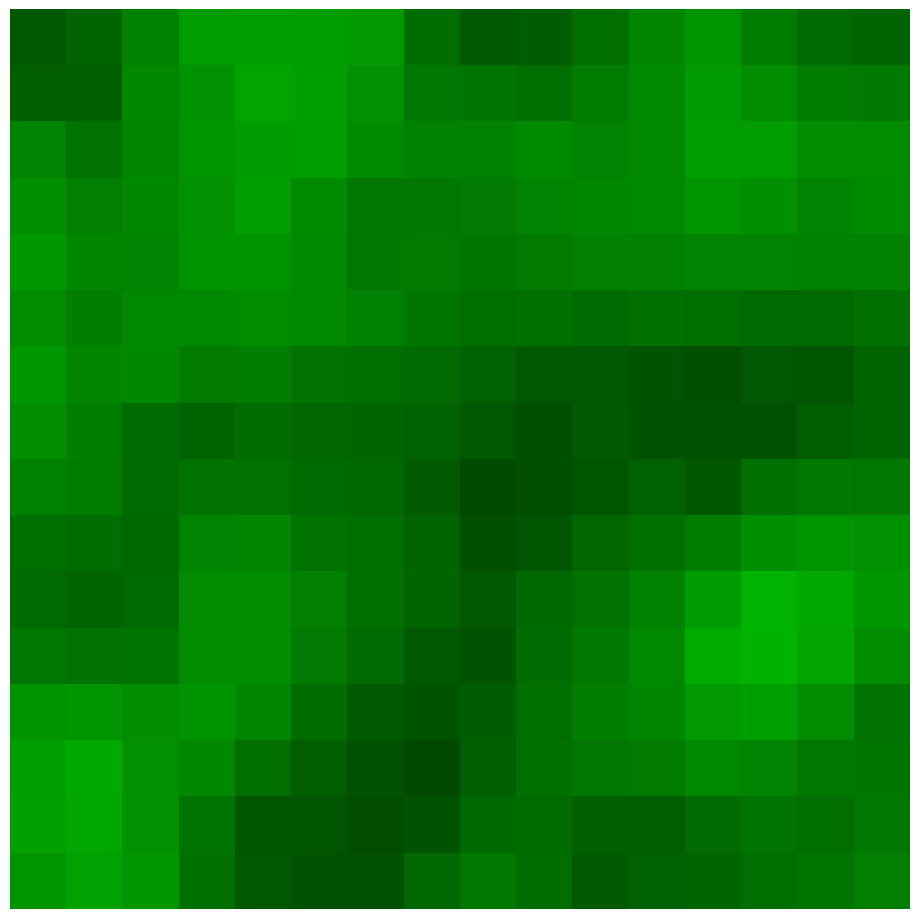

In [3]:
import utils.functions as func
import matplotlib.pyplot as plt

def main():
    """
    Hauptfunktion des Skripts.

    Initialisiert die Parameter, generiert ein Bild, zeigt es an, erstellt eine Animation und speichert sie in einer Datei.
    """
    
    auswahl = func.benutzer_parameter_abfrage()
    
    if auswahl == 'n':
        # User Eingabe zur Bestimmung der Parameter
        params_datei = func.benutzer_parameter_eingabe_und_speichern()
            
    else:
        # User Eingabe zur Auswahl der params Datei
        params_datei = func.user_params_datei_auswahl()

    # Laden Sie die Parameter aus der Datei
    params = func.laden_params(params_datei)

    # Speichern Sie die Parameter in einer Datei
    func.speichern_params(params, 'params/params.json')

    # Laden Sie die Parameter aus der Datei
    params = func.laden_params('params/params.json')

    # Generieren Sie ein Bild
    image = func.generiere_bild(params)

    # Zeige das Bild an
    plt.figure(figsize=(16, 9))  # Optional: Ändern Sie die Größe des Bildes, hier 10x10 Zoll.
    plt.imshow(image)
    plt.axis('off')  # Schaltet die Achsen aus.
    plt.show()

    # Erstelle und speichere die Animation
    func.erstelle_und_speichere_animation(params, 'export/animation.gif')

if __name__ == "__main__":
    main()

Möchten Sie Parameter aus einer Datei laden (l) oder neue Parameter eingeben (n)?  n
Die Breite des Rauschens.
breite (int >= 1):  
Die Höhe des Rauschens.
hoehe (int >= 1):  
Der Zeitpunkt, für den das Rauschen generiert wird.
t (float):  
Der Skalierungsfaktor in x-Richtung.
scale_x (float >= 0):  
Der Skalierungsfaktor in y-Richtung.
scale_y (float >= 0):  
Der Skalierungsfaktor in der Zeitdimension.
scale_t (float >= 0):  
Die Anzahl der Oktaven für das Perlin-Rauschen.
octaves (int >= 1):  
Die Persistenz für das Perlin-Rauschen.
persistence (float zwischen 0 und 1):  
Die Lacunarität für das Perlin-Rauschen.
lacunarity (float >= 1):  
Die Wiederholungsperiode des Rauschens in x-Richtung.
repeatx (int >= 0):  
Die Wiederholungsperiode des Rauschens in y-Richtung.
repeaty (int >= 0):  
Die Wiederholungsperiode des Rauschens in der Zeitdimension.
repeatz (int >= 0):  
Ein Startwert für den Zufallsgenerator.
base (int):  
Der Skalierungsfaktor für die rote Farbkomponente.
rot_scale (

Parameter erfolgreich gespeichert unter params/params.json


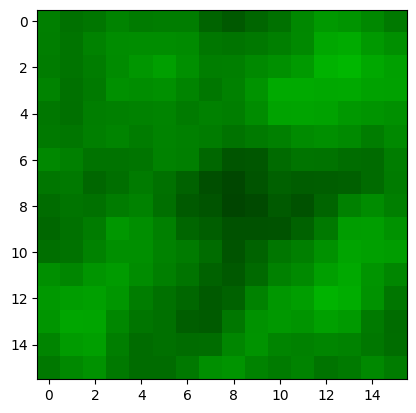

MovieWriter ffmpeg unavailable; using Pillow instead.


export/animation.gif gespeichert


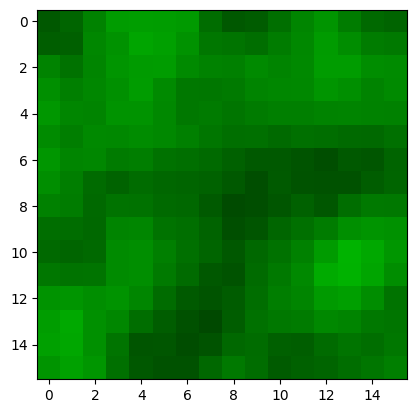

In [1]:
import utils.functions as func
import matplotlib.pyplot as plt

def main():
    """
    Hauptfunktion des Skripts.

    Initialisiert die Parameter, generiert ein Bild, zeigt es an, erstellt eine Animation und speichert sie in einer Datei.
    """
    
    auswahl = func.benutzer_parameter_abfrage()
    
    if auswahl == 'n':
        # User Eingabe zur Bestimmung der Parameter
        params_datei = func.benutzer_parameter_eingabe_und_speichern()
            
    else:
        # User Eingabe zur Auswahl der params Datei
        params_datei = func.user_params_datei_auswahl()

    # Laden Sie die Parameter aus der Datei
    params = func.laden_params(params_datei)

    # Speichern Sie die Parameter in einer Datei
    func.speichern_params(params, 'params/params.json')

    # Laden Sie die Parameter aus der Datei
    params = func.laden_params('params/params.json')

    # Generieren Sie ein Bild
    image = func.generiere_bild(params)

    # Zeige das Bild an
    plt.imshow(image)
    plt.show()

    # Erstelle und speichere die Animation
    func.erstelle_und_speichere_animation(params, 'export/animation.gif')

if __name__ == "__main__":
    main()